In [ ]:
# Authors: Wanli (Kelvin) Cheng, Joelle Sugianto
# Class: CSCI339701 Biomedical Image Analysis
# Professor Donglai Wei

**MRI Brain Tumor Analysis Final Project**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import cv2
import os
import numpy as np

zip_path = "/content/drive/My Drive/braintumor_dataset.zip"
dataset_path = "/content/braintumor_dataset"
training_path = "/content/braintumor_dataset/Training"
testing_path = "/content/braintumor_dataset/Testing"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
import ipywidgets as widgets
import io
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
X_train = []
Y_train = []

image_size = 150

for folder in ['Training', 'Testing']:
    folder_path = os.path.join(dataset_path, folder)
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img,(image_size,image_size))
            if folder == 'Training':
                X_train.append(img)
                Y_train.append(subfolder)
            else:
                X_train.append(img)
                Y_train.append(subfolder)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

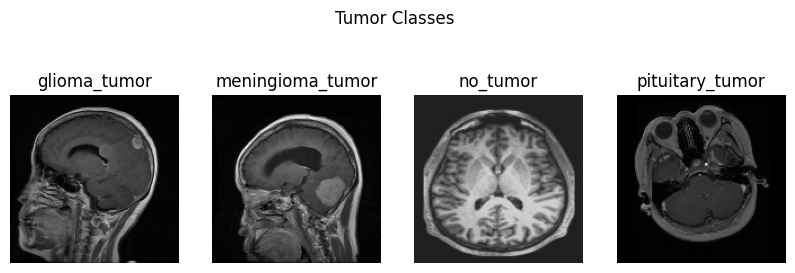

In [ ]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

fig, ax = plt.subplots(1,4,figsize=(10,10))
fig.text(s='Tumor Classes',size=12,color="black",y=0.65,x=0.45)
k = 0
for i in labels:
    j = 0
    while True :
        if Y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(Y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j+=1

In [ ]:
print(X_train.size, Y_train.size)

220320000 3264


In [ ]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size = 0.2,random_state=101)

In [ ]:
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
def resnet34(input_shape, num_classes):
    def identity_block(x, filters):
        shortcut = x
        x = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        x = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        x = keras.layers.Add()([x, shortcut])
        x = keras.layers.Activation('relu')(x)
        return x

    def conv_block(x, filters, strides=(2, 2)):
        shortcut = x
        x = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        x = keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)

        shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = keras.layers.BatchNormalization()(shortcut)

        x = keras.layers.Add()([x, shortcut])
        x = keras.layers.Activation('relu')(x)
        return x

    input = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block(x, filters=64, strides=(1, 1))
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    x = conv_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    x = conv_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    x = conv_block(x, filters=512)
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.models.Model(inputs=input, outputs=x)
    return model

In [ ]:
input_shape = (150, 150, 3)
num_classes = len(np.unique(Y_train))
model = resnet34(input_shape, num_classes)
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 20, validation_split = 0.2)

Epoch 1/20
66/66 [==============================] - 679s 10s/step - loss: 1.3516 - accuracy: 0.5498 - val_loss: 4753.3765 - val_accuracy: 0.2753
Epoch 2/20
66/66 [==============================] - 658s 10s/step - loss: 0.8569 - accuracy: 0.6509 - val_loss: 76.7072 - val_accuracy: 0.1491
Epoch 3/20
66/66 [==============================] - 676s 10s/step - loss: 0.6755 - accuracy: 0.7419 - val_loss: 70.7562 - val_accuracy: 0.1472
Epoch 4/20
66/66 [==============================] - 662s 10s/step - loss: 0.6428 - accuracy: 0.7567 - val_loss: 7.4346 - val_accuracy: 0.2333
Epoch 5/20
66/66 [==============================] - 681s 10s/step - loss: 0.5111 - accuracy: 0.8051 - val_loss: 3.3772 - val_accuracy: 0.3671
Epoch 6/20
66/66 [==============================] - 666s 10s/step - loss: 0.3821 - accuracy: 0.8602 - val_loss: 9.1744 - val_accuracy: 0.1530
Epoch 7/20
66/66 [==============================] - 689s 10s/step - loss: 0.3840 - accuracy: 0.8611 - val_loss: 1.7293 - val_accuracy: 0.5468
E

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

21/21 [==============================] - 67s 3s/step - loss: 1.9978 - accuracy: 0.6508
Test accuracy: 0.6508422493934631


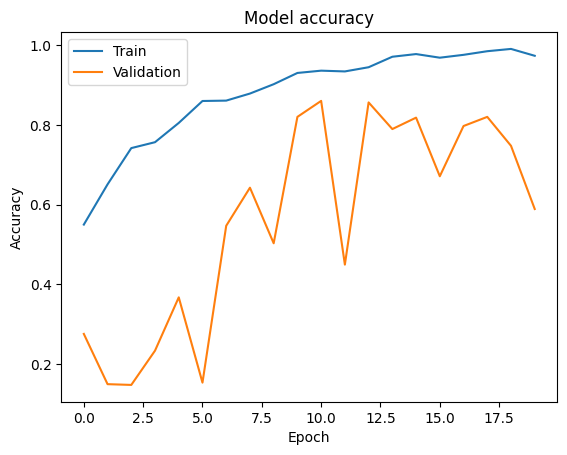

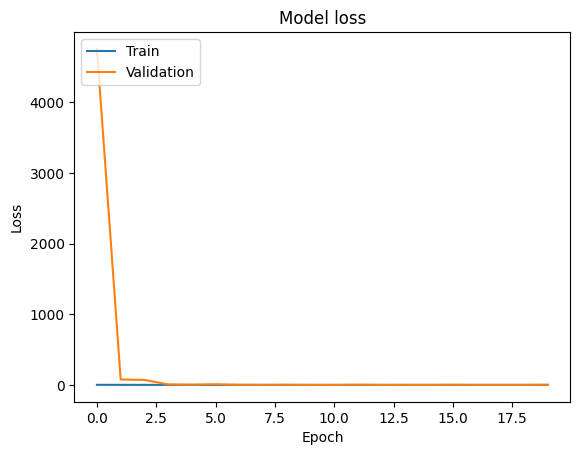

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 47s 2s/step


In [ ]:
# glioma: 0, meningioma: 1, no tumor: 2, pituitary: 3
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.66      0.82      0.73       168
           1       0.87      0.56      0.68       201
           2       0.43      0.99      0.60       108
           3       1.00      0.39      0.56       176

    accuracy                           0.65       653
   macro avg       0.74      0.69      0.64       653
weighted avg       0.78      0.65      0.65       653



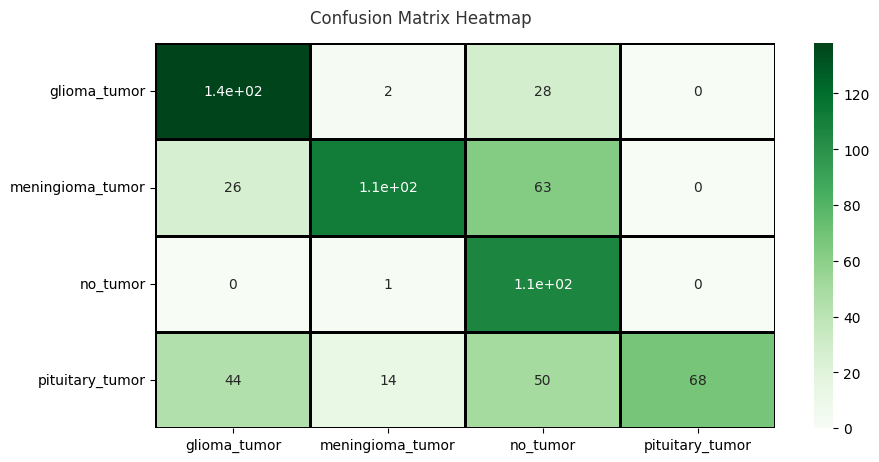

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap="Greens",linewidths=1,linecolor="black")
fig.text(s='Confusion Matrix Heatmap',size=12,color="black",y=0.92,x=0.28,alpha=0.8)

plt.show()

1/1 [==============================] - 0s 116ms/step


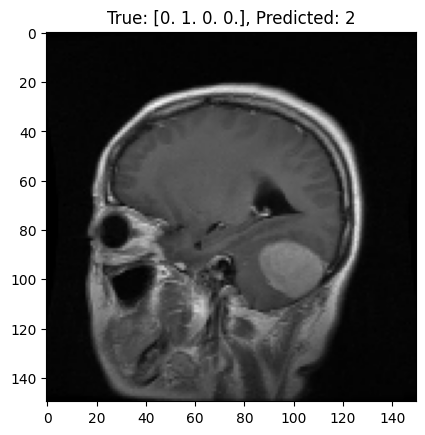

In [ ]:
# Select a random sample from the test set
idx = np.random.randint(len(X_test))
x = X_test[idx]
y_true = y_test[idx]

# Make a prediction on the sample
y_pred = model.predict(x[np.newaxis,...])
y_pred_class = np.argmax(y_pred, axis=1)

# Visualize the sample and its true/predicted label
plt.imshow(x)
plt.title(f'True: {y_true}, Predicted: {y_pred_class[0]}')
plt.show()